In [1]:
from resources.workspace import *

/Users/brajard/Documents/recherche/collaboration/bigdata/DAPPER


### The Gaussian (i.e. Normal) distribution

Consider the random variable with a Gaussian distribution with mean $\mu$ (`mu`) and variance $P$. We write its probability density function (**pdf**) as
$$ p(x) = N(x|\mu,P) = (2 \pi P)^{-1/2} e^{-(x-\mu)^2/2P} \, .  \qquad \qquad (1) $$

---
**Exc 2.2:** Code it up (complete the code below)! Hints:
* Note that `**` is the power operator in Python.
* As in Matlab, $e^x$ is available as `exp(x)`

In [3]:
# Univariate (scalar), Gaussian pdf
def pdf_G_1(x,mu,P):
    # pdf_values = ### INSERT ANSWER HERE ###
    return sp.stats.norm.pdf(x,loc=mu,scale=sqrt(P))

In [4]:
show_answer('pdf_G_1')

Let's plot the pdf.

<IPython.core.display.Javascript object>


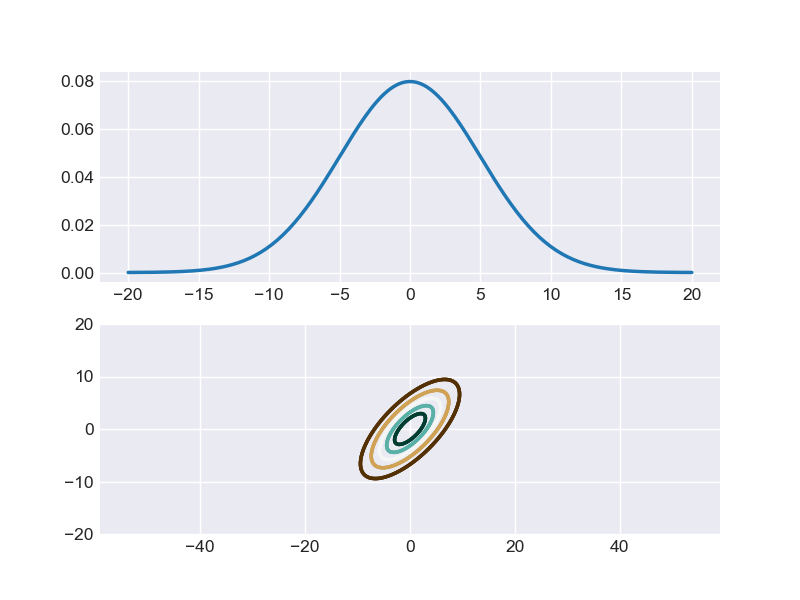

In [5]:
mu  = 0                 # mean     of distribution
P   = 25                # variance of distribution
P12 = sqrt(P)           # std. dev of distribution

# Plotting
N  = 201                # num of grid points
xx = linspace(-20,20,N) # grid
dx = xx[1]-xx[0]        # grid spacing
pp = pdf_G_1(xx,mu,P)   # pdf values
plt.subplot(211)        # allocate plot panel
plt.plot(xx,pp);        # plot

This could for example be the pdf of a stochastic noise variable. It could also describe our uncertainty about a parameter (or state), which we model as randomness in the Bayesian paradigm.

**Exc 2.4:** Change `P` in the above code, and re-run the cell. Look at the figure.
 * How does the pdf curve change when you increase P?
 * Re-set `P=25` and re-run (this is a convienient value for examples)

**Exc 2.6:** Recall $p(x)$ from eqn (1). The following are helpful points to remember how it looks. Use pen, paper, and calculus. Hint: it's typically easier to analyse $\log p(x)$ rather than $p(x)$ itself.
 * Where is the location of the mode (maximum) of the distribution? I.e. where $\frac{d p(x)}{d x} = 0$.
 * Where is the inflection point? I.e. where $\frac{d^2 p(x)}{d x^2} = 0$.
 * What is the value of $\frac{d^2 \log p(x)}{d x^2}$ at the mode?

#### The multivariate (i.e. vector) case
Here's the pdf of the *multivariate* Gaussian:
\begin{align}
N(x|\mu,P) &= |2 \pi P|^{-\frac{1}{2}} e^{-\frac{1}{2}\|x-\mu\|^2_P} \, , \\\
\end{align}
where $|.|$ represents the determinant, and $\|.\|_W$ represents the norm with weighting: $\|x\|^2_W = x^T W^{-1} x$.

The following implements this pdf. Take a moment to digest the code; in particular, it should be noted that `pdf_G_m()` can accept multiple `x` vectors at once (assembled into a matrix), whence the `xx` naming convention.

In [6]:
from numpy.linalg import det, inv

def weighted_norm22(xx,W):
    # Computes the norm of each row vector of xx, as weighted by W.
    return np.sum((xx @ inv(W)) * xx, axis=1)

def pdf_G_m(xx,mu,P):
    return 1/sqrt(det(2*pi*P))*exp(-0.5*weighted_norm22(xx-mu,P))

The following code plots the pdf as contour (equi-density) curves.
The plot appears in the above figure.

In [9]:
def list_2_array(grid): return array([xi.ravel() for xi in grid]).T
def square_reshape(X):  return X.reshape(int(sqrt(len(X))),-1)

grid = np.meshgrid(xx,xx)
grid = list_2_array(grid)

pp = pdf_G_m(grid, 0, P*array([[1,0.7],[0.7,1]]))
pp = square_reshape(pp)

plt.subplot(212)
plt.contour(xx,xx,pp);
plt.axis('equal');
plt.show()

/Users/brajard/anaconda/envs/nn/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


**Exc 2.8:**
 * Set the correlation to 0. How do the contours look?
 * Set the correlations to 0.99. How do the contours look?

**Exc 2.9:** Go play the [correlation game](http://guessthecorrelation.com/)

### Bayes' rule
Bayes' rule is how we do inference. For continuous random variables, $x$ and $y$, it reads:

$$ p(x|y) = \frac{p(x) \, p(y|x)}{p(y)} \, , \qquad \qquad (2)$$

or, in words:


$$
\text{"posterior" (pdf of $x$ given $y$)}
\; = \;
\frac{\text{"prior" (pdf of $x$)}
\; \times \;
\text{"likelihood" (pdf of $y$ given $x$)}}
{\text{"normalization" (pdf of $y$)}}
$$.

**Exc 2.10:** Derive Bayes' rule from the definition of [conditional pdf's](https://en.wikipedia.org/wiki/Conditional_probability#Kolmogorov_definition).

In [10]:
show_answer('BR deriv')

Computers generally work with discrete, numerical representations of mathematical entities.
Numerically, pdfs may be represented by their `values` on a grid, such as `xx` from above. Bayes' rule (2) then consists of *(grid-)point-wise* multiplication, as shown below.

In [11]:
def Bayes_rule(prior_values,lklhd_values,dx):
    pp = prior_values * lklhd_values   # pointwise multiplication
    posterior_values = pp/(sum(pp)*dx) # normalization
    return posterior_values

**Exc 2.12:** Why does `Bayes_rule()` not need the values of the denominator, $p(y)$, as input?

In [12]:
show_answer('BR grid normalization')

In fact, since normalization is so simple, we often don't bother to do it until it's strictly necessary. Therefore we often simplify Bayes' rule (2) as
$$ p(x|y) \propto p(x) \, p(y|x) \, .  \qquad \qquad (3) $$



---
The code below show's Bayes' rule in action. Again, remember that the only thing it's doing is multiplying the prior and likelihood at each gridpoint. Move the sliders with the arrow keys to animate it.

In [13]:
%matplotlib inline

b = 0 # prior mean
B = 1 # prior variance

@interact(y=(-10,10,1),log_R=(-2,5,0.5))
def animate_Gaussian_Bayes(y=4.0,log_R=1):

    R = exp(log_R)

    prior     = lambda x: pdf_G_1(x,b,B)
    lklhd     = lambda x: pdf_G_1(y,x,R)
    
    post_vals = Bayes_rule(prior(xx),lklhd(xx),xx[1]-xx[0])

    plt.figure(figsize=(10,4))
    plt.plot(xx,prior(xx)     ,label='prior N(x|0,1)')
    plt.plot(xx,lklhd(xx)     ,label='likelihood N(y|x,R)')
    plt.plot(xx,post_vals     ,label='posterior - pointwise')
    
    ### Uncomment this block AFTER doing the exercise ###
    ### that defines Bayes_rule_Gaussian()            ###
    #mu, P     = Bayes_rule_Gaussian(b,B,y,R)
    #postr     = lambda x: pdf_G_1(x,mu,P)
    #plt.plot(xx,postr(xx),'--',label='posterior - parametric')
    
    plt.ylim(ymax=0.6)
    plt.legend()
    plt.show()

**Exc 2.14:** Answer the following by moving the sliders and seeing what happens.
 * What happens to the posterior when $R \rightarrow \infty$ ?
 * What happens to the posterior when $R \rightarrow 0$ ?
 * Where is the posterior when $R = B$ ? (try moving around $y$)
 * Does the posterior scale (width) depend on $y$?
 * Forgetting about its location and scale, what is the shape of the posterior? Does this depend on $R$ or $y$? Can you see why?
 * Can you see a shortcut to computing this posterior rather than having to do the pointwise multiplication?

**Exc 2.15*:** Implement a "uniform" (or "flat" or "box") distribution pdf and call it `pdf_U_1(x,mu,P)`. These <a href="https://en.wikipedia.org/wiki/Uniform_distribution_(continuous)#Moments">formulae</a> for its mean/variance will be useful. In the above animations, replace `pdf_G_1` with your new `pdf_U_1` (both for the prior and likelihood). Assure that everything is working correctly. 
 - Why (in the figure) are the walls of the pdf (ever so slightly) inclined?
 - What happens when you move the prior and likelihood very far apart? Is the fault of the implementation, or the fundamental assumptions (uniform distribution)?
 - Re-do Exc 2.14, now with `pdf_U_1`.
 - Now test a Gaussian prior with a uniform likelihood.
 - Restore `pdf_G_1` (both the prior and likelihood) in the animation (for later use).
 

In [14]:
show_answer('pdf_U_1')

### Gaussian-Gaussian Bayes

The above animation shows Bayes' rule in 1 dimension. Previously, we saw how a Gaussian looks in 2 dimensions. Can you imagine how Bayes' rule looks in 2 dimensions? In higher dimensions, these things get difficult to imagine, let alone visualize.

Similarly, the size of the calculations required for Bayes' rule poses a difficulty. Indeed, the following exercise shows that (pointwise) multiplication for all grid points becomes a preposterious notion in high dimensions.

**Exc 2.16:**
 * (a) How many point-multiplications are needed on a grid with $N$ points in $m$ dimensions? (Imagine an $m$-dimensional cube where each side has a grid with $N$ points on it)
 * (b) Suppose we model 15 physical quanitites, on each grid point, on a discretized model of Earth. Assume the resolution is $1^\circ$ for latitude (110km), $1^\circ$ for longitude. How many variables are there in total? This is the dimensionality ($m$) of the problem.
 * (c) Suppose each variable is has a pdf represented with a grid using only $N=10$ points. How many multiplications are necessary to calculate Bayes rule (jointly) for all variables on our Earth model?

In [15]:
show_answer('Dimensionality a')
show_answer('Dimensionality b')
show_answer('Dimensionality c')

In response to this computational difficulty, we try to be smart and do something more analytical ("pen-and-paper"): we only compute the parameters (mean and (co)variance) of the posterior pdf.

This is doable and quite simple in the Gaussian-Gaussian case.
With a prior $p(x) = N(x|b,B)$ and a likelihood $p(y|x) = N(y|x,R)$, the posterior will be given by
\begin{align}
p(x|y)
&= N(x|\mu,P) \qquad \qquad (4) 
\, ,
\end{align}
where, in the univarite (1-dimensional) case:
\begin{align}
    P &= 1/(1/B + 1/R) \, , \qquad \qquad (5) \\\
  \mu &= P(b/B + y/R) \, .  \qquad \qquad (6) 
\end{align}


#### Exc  2.18 'Gaussian Bayes':
Derive the above expressions for $P$ and $\mu$.
*Hint: you need eqns (1) and (3).*

In [16]:
show_answer('BR Gauss')

**Exc 2.20:** Do some light algebra to show that eqns (5) and (6) can be rewritten as
\begin{align}
    P &= (1-K)B \, ,  \qquad \qquad (8) \\\
  \mu &= b + K (y-b)  \qquad \quad (9) \, ,
\end{align}
where $K = B/(B+R)$, which is called the "Kalman gain".

**Exc 2.22*:** Consider the formula for $K$ and its role in the previous couple of equations... Why do you think $K$ is called a "gain"?

In [17]:
show_answer('KG 2')

**Exc 2.24:** Implement a Gaussian-Gaussian Bayes' rule by completing the code below.

In [ ]:
def Bayes_rule_Gaussian(b,B,y,R):
    ### INSERT ANSWER HERE ###
    return mu,P

In [18]:
show_answer('BR Gauss code')

**Exc 2.26:** Then, go back to the animation above, and uncomment the block that makes use of `Bayes_rule_Gaussian()`. Make sure its curve coincides with that which uses pointwise multiplication (i.e. `Bayes_rule()`).

**Exc 2.28:** More questions related to the above animation:
 * Does the width (i.e. scale) for the posterior depend on the location $y$ of the likelihood?
 * Is the width (i.e. scale) for the posterior always smaller that that of prior and likelihood? What does this mean information-wise?
   * Do you think this is always the case, also for non-Gaussian distributions?
 * What if you're pretty sure about something, and you get a wildly different indication (observation). What is your posterior certainty?

**Exc 2.30*:** Why are we so fond of the Gaussian assumption?

In [19]:
show_answer('why Gaussian')

### Next: [Univariate (scalar) Kalman filtering](T3 - Univariate Kalman filtering.ipynb)